<a href="https://colab.research.google.com/github/LizcanoJuan1010/Machine-Learning-Projects/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Descripción del Proyecto (CRISP-DM)
## Juan José Lizcano Barbosa
Se tiene un conjunto de registros de mediciones realizadas a conductores mientras estaban manejando en condiciones reales (archivo alerta_train.xlsx, hoja train). Una cámara puesta en el vehículo registró en un momento específico del viaje de manera aleatoria si la persona estaba alerta o no, y con ayuda de sensores y una encuesta se registraron 11 variables para determinar qué factores permiten predecir si una persona está alerta o no al manejar. El nivel de alerta es fundamental para evitar accidentes de tránsito.  Usted debe:
### a)	 desarrollar un modelo predictivo para los elementos de la hoja “predecir” (se debe enviar un archivo Excel o csv sólo con las columnas id y isalert)
### b)	Desarrollar un reporte del modelo realizado con CRISP-DM que Incluya elementos de explicabilidad del modelo realizado en el contexto del problema



#Extraccion de datos

In [ ]:
# Para manipulación de datos
import pandas as pd
import numpy as np

# Para división de datos y métricas de evaluación
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report, confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler

# Modelos de Clasificación
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
df=pd.read_excel('/content/trainn.xlsx')

In [ ]:
df_test=pd.read_excel('/content/alerta.xlsx')

#EDA y comprension de los datos

Campos de la base de datos:


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349999 entries, 0 to 349998
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   P1       349999 non-null  float64
 1   P2       349999 non-null  float64
 2   P6       349999 non-null  int64  
 3   V2       349999 non-null  float64
 4   V3       349999 non-null  int64  
 5   V4       349999 non-null  float64
 6   V5       349999 non-null  int64  
 7   V6       349999 non-null  int64  
 8   V8       349999 non-null  float64
 9   V10      349999 non-null  int64  
 10  V11      349999 non-null  float64
 11  isalert  349999 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 32.0 MB


In [ ]:
df.head()

,P1,P2,P6,V2,V3,V4,V5,V6,V8,V10,V11,isalert
0,27.3075,12.06200,904,0.00,240,3.01875,0,1760,15.8,4,5.93357,0
1,31.1577,6.51771,736,-0.07,255,1.48750,0,2221,30.8,4,9.68883,1
2,37.2833,15.89150,836,-0.07,255,3.01875,0,1944,32.3,4,8.43027,0
3,35.8910,11.64680,844,-0.07,240,0.00000,0,2141,13.9,4,6.05122,0
4,29.1790,10.06800,900,0.28,496,4.50625,0,2174,21.3,4,9.34283,0


In [ ]:
df.describe()

,P1,P2,P6,V2,V3,V4,V5,V6,V8,V10,V11,isalert
count,349999.000000,349999.000000,349999.000000,349999.000000,349999.000000,349999.000000,349999.000000,349999.000000,349999.000000,349999.000000,349999.000000,349999.000000
mean,34.552180,12.002244,816.315018,-0.003346,556.026283,3.902171,0.135140,1831.298612,13.853509,3.515427,10.692864,0.591005
std,5.285719,3.540917,179.802236,0.283293,295.599245,3.673595,0.341874,544.749207,11.241747,1.084315,3.767221,0.491649
min,20.131900,0.035973,368.000000,-2.835000,240.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.038370,0.000000
25%,31.304500,9.997400,672.000000,-0.070000,255.000000,1.487500,0.000000,1820.000000,0.000000,4.000000,7.597135,0.000000
50%,33.841800,11.416700,812.000000,0.000000,496.000000,3.018750,0.000000,2031.000000,14.900000,4.000000,9.743660,1.000000
75%,36.828600,13.591900,924.000000,0.070000,767.000000,5.993750,0.000000,2163.000000,22.600000,4.000000,14.534250,1.000000
max,54.537300,40.382600,1704.000000,2.135000,1023.000000,24.018800,1.000000,4892.000000,68.900000,7.000000,20.039800,1.000000


In [ ]:

df_standardized = df.copy()

# Seleccionar solo las columnas numéricas para la estandarización
numeric_cols = df_standardized.select_dtypes(include=np.number).columns.tolist()

# Excluir columnas de identificación si existen y no son relevantes para el modelo (e.g., 'id')
# Ajusta esto si tu DataFrame tiene una columna 'id' o similar
if 'id' in numeric_cols:
    numeric_cols.remove('id')

# Inicializar el StandardScaler
scaler = StandardScaler()

# Aplicar la estandarización a las columnas numéricas seleccionadas
df_standardized[numeric_cols] = scaler.fit_transform(df_standardized[numeric_cols])

# Imprimir las primeras filas del DataFrame estandarizado para verificar
print("DataFrame estandarizado:")
print(df_standardized.head())


DataFrame estandarizado:
         P1        P2        P6        V2        V3        V4        V5  \
0 -1.370616  0.016876  0.487675  0.011810 -1.069105 -0.240479 -0.395294   
1 -0.642199 -1.548904 -0.446686 -0.235285 -1.018361 -0.657306 -0.395294   
2  0.516699  1.098377  0.109481 -0.235285 -1.018361 -0.240479 -0.395294   
3  0.253290 -0.100382  0.153975 -0.235285 -1.069105 -1.062223 -0.395294   
4 -1.016548 -0.546256  0.465429  1.000188 -0.203067  0.164438 -0.395294   

         V6        V8       V10       V11   isalert  
0 -0.130884  0.173149  0.446894 -1.263345 -1.202088  
1  0.715379  1.507463  0.446894 -0.266519  0.831886  
2  0.206887  1.640894  0.446894 -0.600601 -1.202088  
3  0.568522  0.004136  0.446894 -1.232115 -1.202088  
4  0.629100  0.662397  0.446894 -0.358364 -1.202088  


In [ ]:
df_standardized.head()

,P1,P2,P6,V2,V3,V4,V5,V6,V8,V10,V11,isalert
0,-1.370616,0.016876,0.487675,0.011810,-1.069105,-0.240479,-0.395294,-0.130884,0.173149,0.446894,-1.263345,-1.202088
1,-0.642199,-1.548904,-0.446686,-0.235285,-1.018361,-0.657306,-0.395294,0.715379,1.507463,0.446894,-0.266519,0.831886
2,0.516699,1.098377,0.109481,-0.235285,-1.018361,-0.240479,-0.395294,0.206887,1.640894,0.446894,-0.600601,-1.202088
3,0.253290,-0.100382,0.153975,-0.235285,-1.069105,-1.062223,-0.395294,0.568522,0.004136,0.446894,-1.232115,-1.202088
4,-1.016548,-0.546256,0.465429,1.000188,-0.203067,0.164438,-0.395294,0.629100,0.662397,0.446894,-0.358364,-1.202088


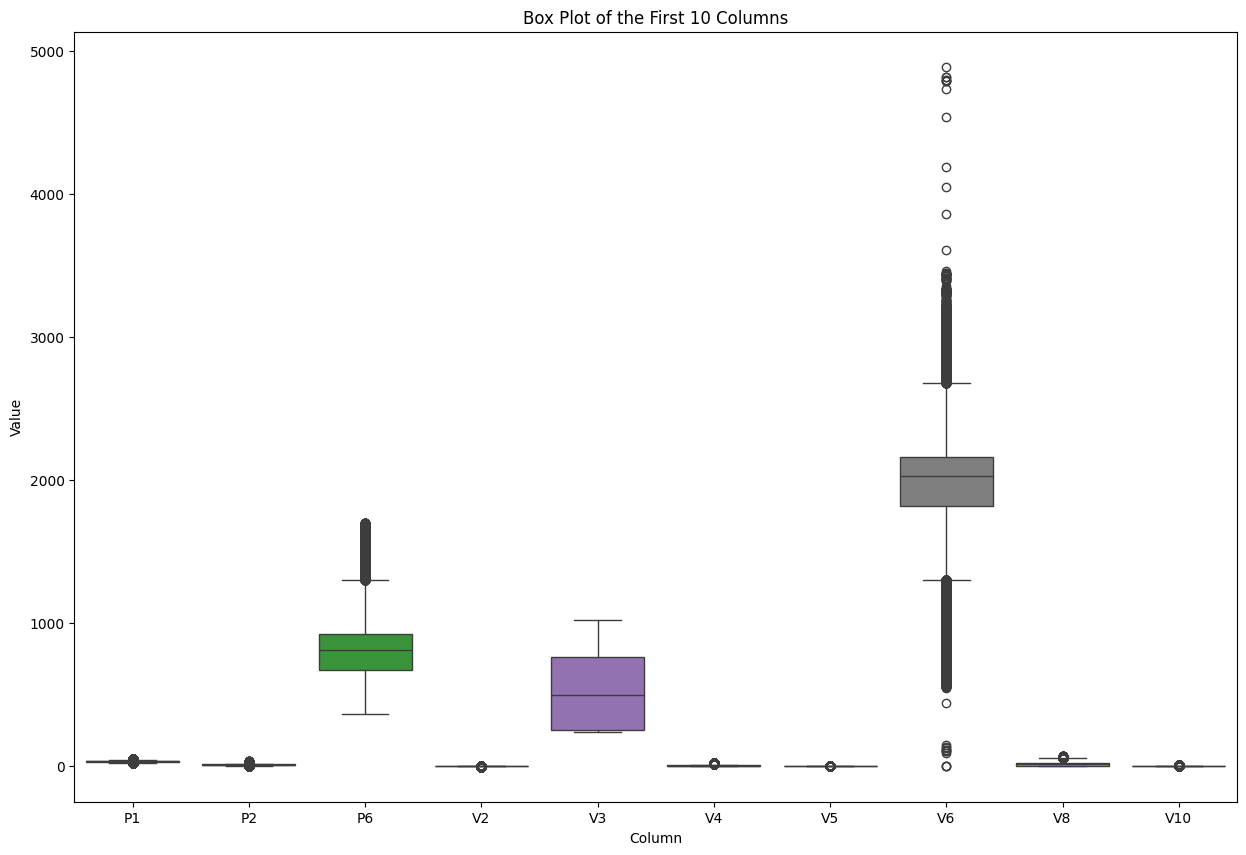

In [ ]:

plt.figure(figsize=(15, 10))
sns.boxplot(data=df.iloc[:, :10])
plt.title('Box Plot of the First 10 Columns')
plt.ylabel('Value')
plt.xlabel('Column')
plt.show()

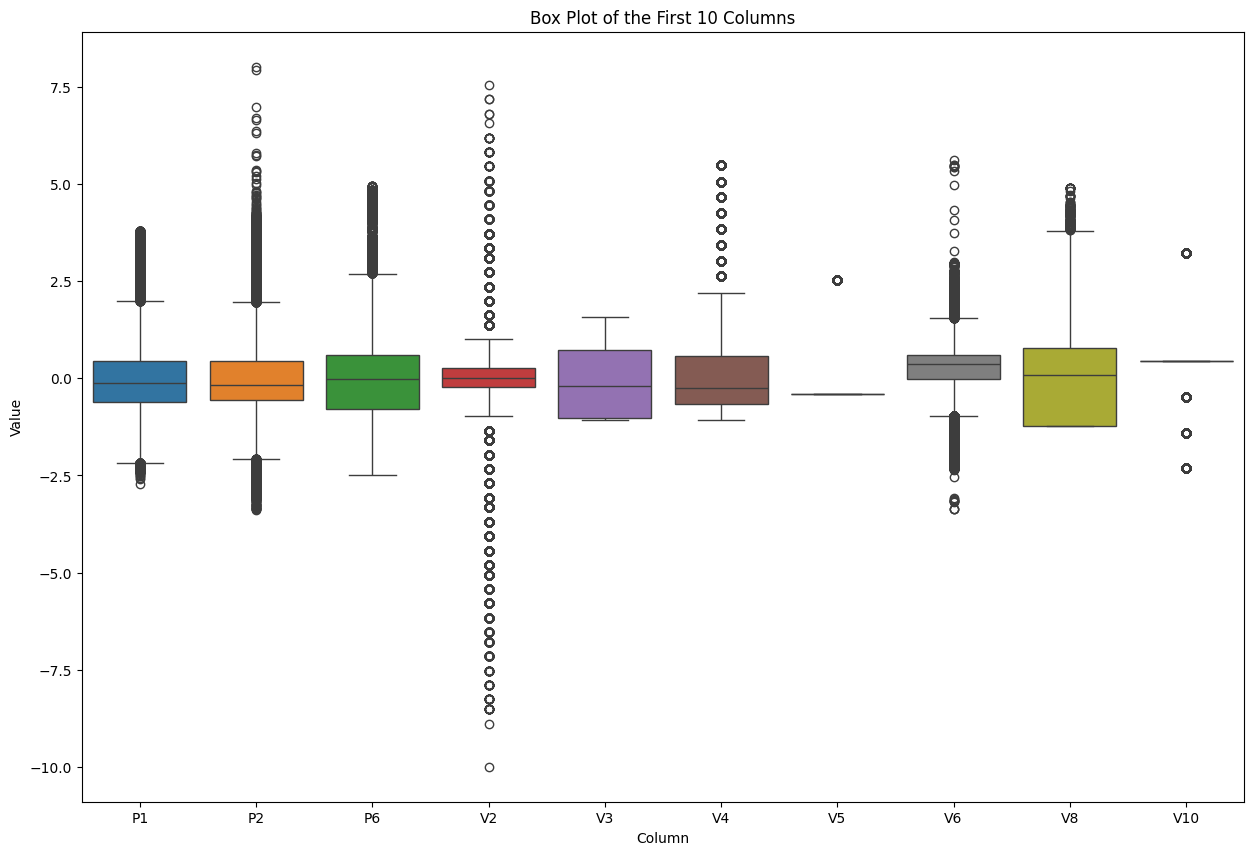

In [ ]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_standardized.iloc[:, :10])
plt.title('Box Plot of the First 10 Columns')
plt.ylabel('Value')
plt.xlabel('Column')
plt.show()

Variables con outliers para revisar:
* veces que se desperto la noche anterior
* Años desde la obtención de la licencia de conducir
* V4	Velocidad en la via (en km/h)
* V6 temperatura


Matriz de Correlación de la base estandarizada:
               P1        P2        P6        V2        V3        V4        V5  \
P1       1.000000  0.008240 -0.102980 -0.007767 -0.000202  0.001543  0.017702   
P2       0.008240  1.000000 -0.030967 -0.001971  0.000150  0.002355 -0.006030   
P6      -0.102980 -0.030967  1.000000 -0.025010  0.012319  0.073428 -0.049183   
V2      -0.007767 -0.001971 -0.025010  1.000000 -0.020690  0.160222 -0.379415   
V3      -0.000202  0.000150  0.012319 -0.020690  1.000000  0.006701 -0.050211   
V4       0.001543  0.002355  0.073428  0.160222  0.006701  1.000000 -0.123142   
V5       0.017702 -0.006030 -0.049183 -0.379415 -0.050211 -0.123142  1.000000   
V6       0.006792 -0.003804 -0.041539  0.057547  0.248134 -0.270215 -0.195091   
V8      -0.020337 -0.001639 -0.031110  0.019010  0.150067 -0.105724 -0.099599   
V10      0.000063 -0.000214 -0.042147  0.089081  0.279282 -0.277464 -0.217160   
V11      0.190108  0.055788 -0.285273 -0.074160 -0.009342  0

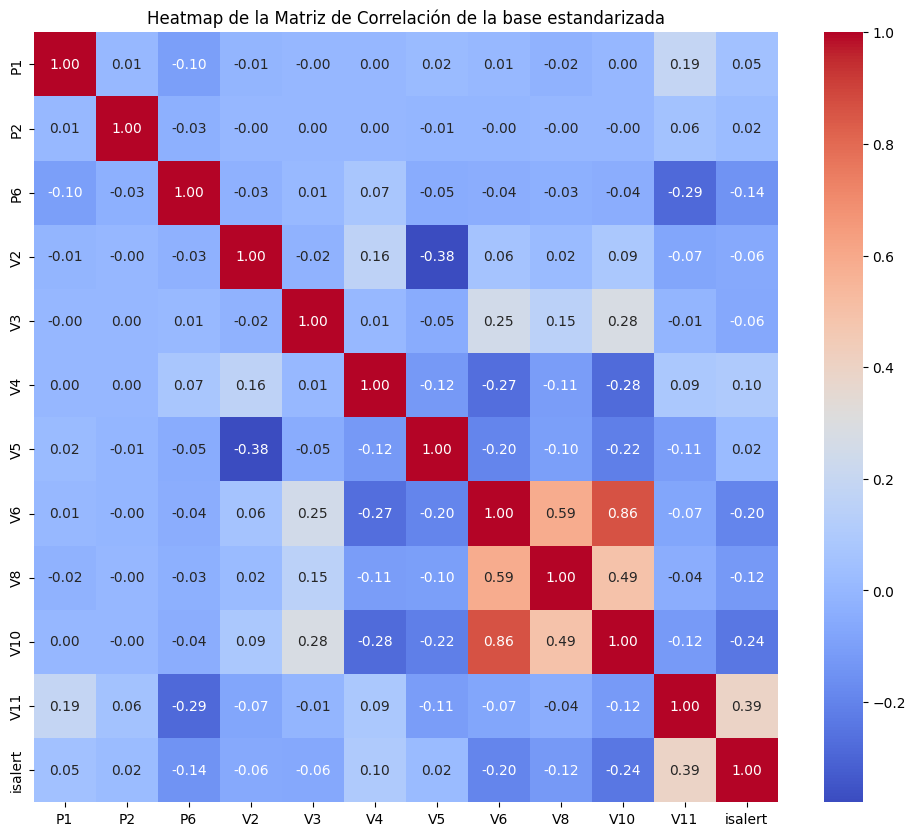

In [ ]:

# Calcular la matriz de correlación de la base estandarizada
correlation_matrix_standardized = df_standardized.corr()

# Imprimir la matriz de correlación
print("\nMatriz de Correlación de la base estandarizada:")
print(correlation_matrix_standardized)

# Opcional: Visualizar la matriz de correlación usando un heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_standardized, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de la Matriz de Correlación de la base estandarizada')
plt.show()

Interacciones:
* V6 y V10
*V6 Y v8


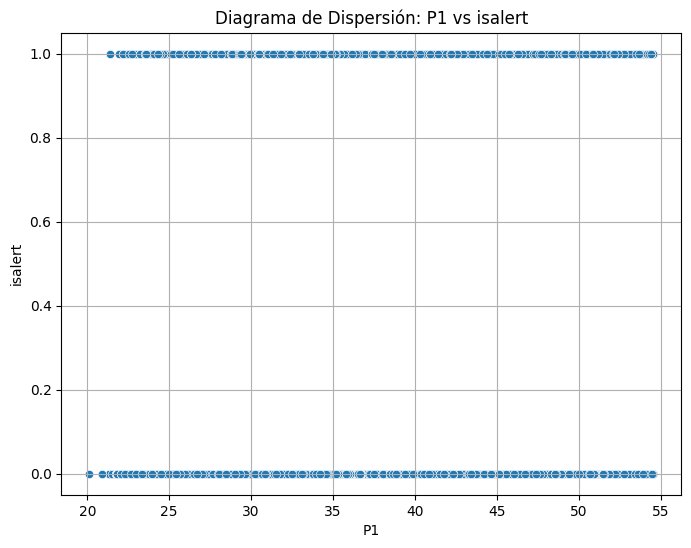

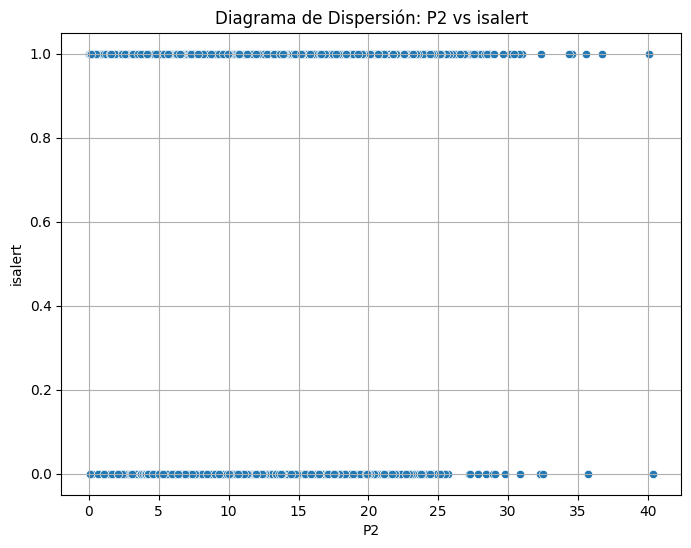

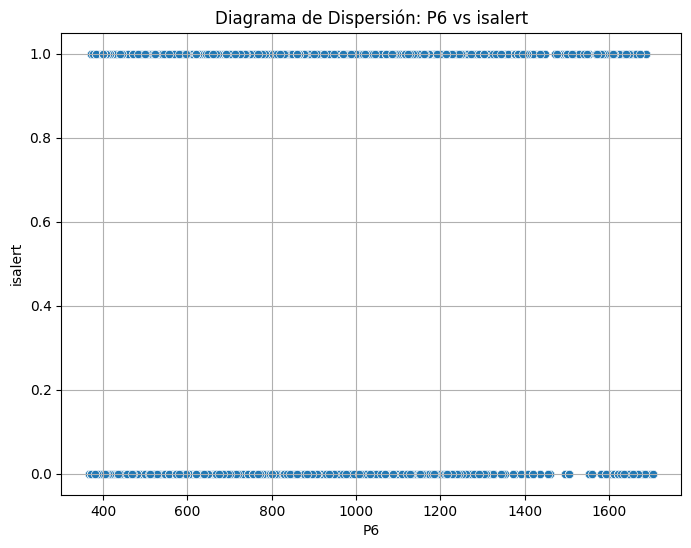

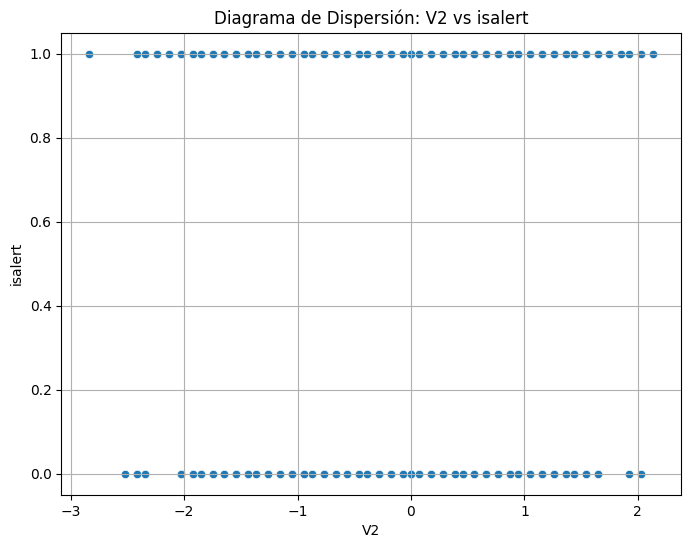

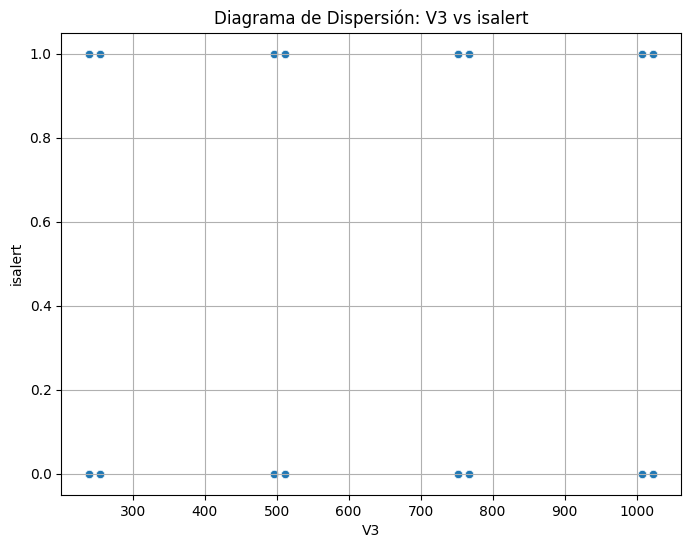

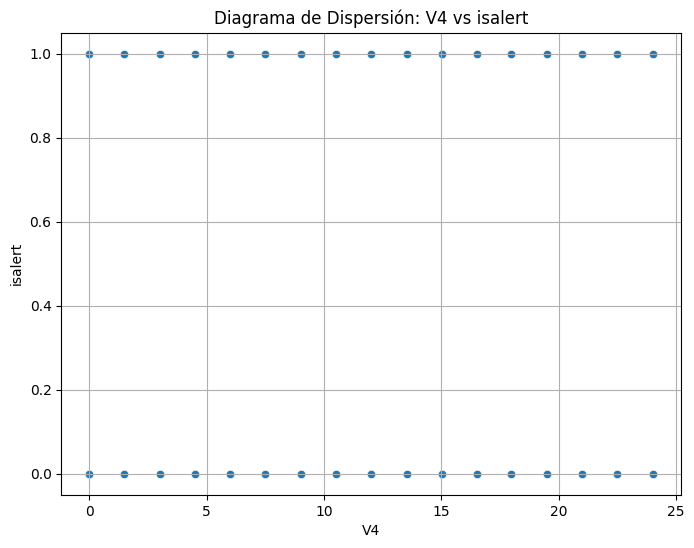

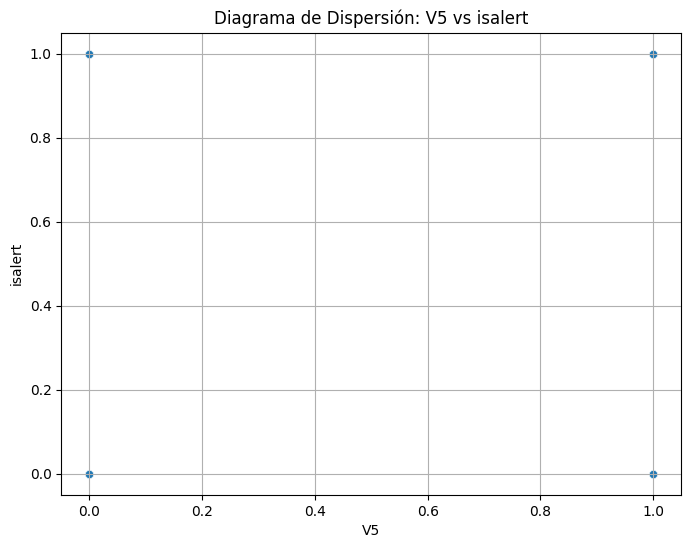

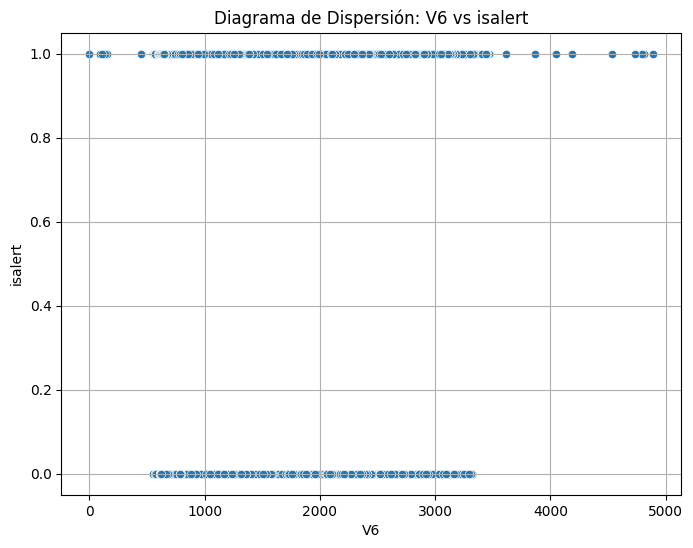

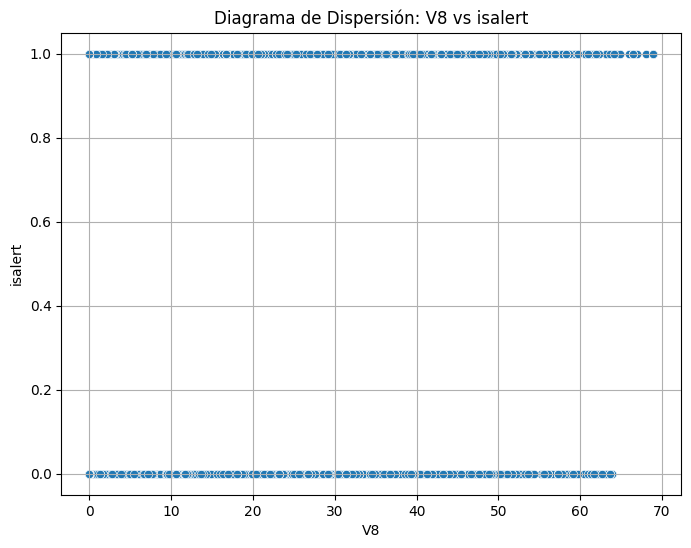

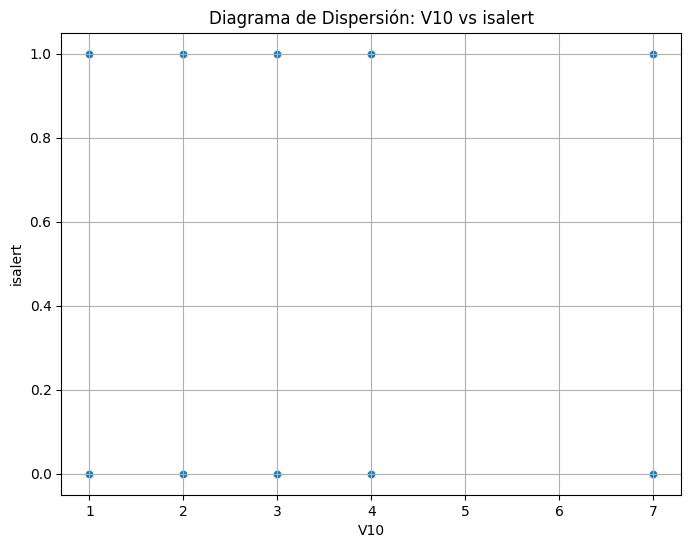

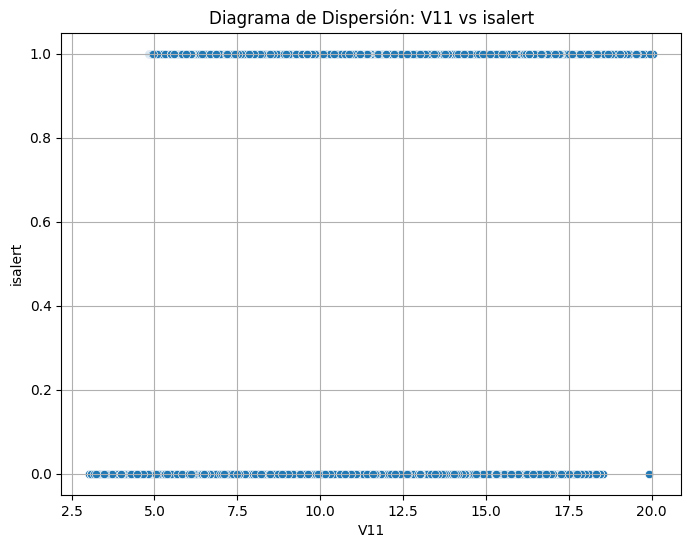

In [ ]:

if 'isalert' in df.columns:
    # Iterar sobre cada columna del DataFrame, excepto 'isalert'
    for column in df.columns:
        if column != 'isalert':
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=df[column], y=df['isalert'])
            plt.title(f'Diagrama de Dispersión: {column} vs isalert')
            plt.xlabel(column)
            plt.ylabel('isalert')
            plt.grid(True)
            plt.show()
else:
    print("La columna 'isalert' no se encuentra en el DataFrame.")

#Split

Separacion de datos en train y test:

In [ ]:
random_state = 42
X = df.drop('isalert', axis=1)
y = df['isalert']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


#Balanceo

In [ ]:
X_train.shape, y_train.shape

((279999, 11), (279999,))

In [ ]:
y_train.value_counts()

,count
isalert,
1,165215
0,114784


In [ ]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tl.fit_resample(X_train, y_train)

print("Shape before Tomek Links:", X_train.shape)
print("Shape after Tomek Links:", X_train_resampled.shape)
print("Class distribution after Tomek Links:\n", y_train_resampled.value_counts())


Shape before Tomek Links: (279999, 11)
Shape after Tomek Links: (273666, 11)
Class distribution after Tomek Links:
 isalert
1    158882
0    114784
Name: count, dtype: int64


In [ ]:
from sklearn.utils import resample

# 1. Separar la clase minoritaria (0) de los datos post-Tomek Links
X_train_minority_post_tomek = X_train_resampled[y_train_resampled == 0]
y_train_minority_post_tomek = y_train_resampled[y_train_resampled == 0]

X_minority_oversampled, y_minority_oversampled = resample(
    X_train_minority_post_tomek,
    y_train_minority_post_tomek,
    replace=True,
    n_samples=158882,
    random_state=42
)

# 3. Separar la clase mayoritaria (1) de los datos post-Tomek Links
X_train_majority_post_tomek = X_train_resampled[y_train_resampled == 1]
y_train_majority_post_tomek = y_train_resampled[y_train_resampled == 1]

# 4. Combinar la clase mayoritaria (original post-Tomek) con la clase minoritaria sobremuestreada
X_combined_balanced = pd.concat([X_train_majority_post_tomek, X_minority_oversampled])
y_combined_balanced = pd.concat([y_train_majority_post_tomek, y_minority_oversampled])


In [ ]:
X_combined_balanced.head()

,P1,P2,P6,V2,V3,V4,V5,V6,V8,V10,V11
0,30.7848,10.30590,844,-0.070,255,10.50000,0,648,0.0,1,14.00190
1,35.5415,5.83381,1072,0.000,240,3.01875,0,2272,22.8,4,6.77837
3,34.7014,12.80210,928,0.000,255,11.98750,1,630,0.0,4,13.75100
4,41.2271,11.87410,664,0.070,511,3.01875,0,2154,23.4,4,11.46960
5,49.1350,9.71870,708,-0.175,767,1.48750,1,2212,0.0,4,10.83630


In [ ]:
y_combined_balanced.value_counts()

,count
isalert,
1,158882
0,158882


Se decidio usar una tecnica de duplicar datos para evitar usar smote e implementar datos sinteticos, esto implica que se crearon 4000 copias de los 1000 datos existentes en el entrenamiento

#Feature Engineering

In [ ]:
X_combined_balanced.head()

,P1,P2,P6,V2,V3,V4,V5,V6,V8,V10,V11
0,30.7848,10.30590,844,-0.070,255,10.50000,0,648,0.0,1,14.00190
1,35.5415,5.83381,1072,0.000,240,3.01875,0,2272,22.8,4,6.77837
3,34.7014,12.80210,928,0.000,255,11.98750,1,630,0.0,4,13.75100
4,41.2271,11.87410,664,0.070,511,3.01875,0,2154,23.4,4,11.46960
5,49.1350,9.71870,708,-0.175,767,1.48750,1,2212,0.0,4,10.83630


In [ ]:
X_combined_balanced['V6_x_V8'] = X_combined_balanced['V6'] * X_combined_balanced['V8']
X_combined_balanced['V6_x_V10'] = X_combined_balanced['V6'] * X_combined_balanced['V10']
print(X_combined_balanced.head())

        P1        P2    P6     V2   V3        V4  V5    V6    V8  V10  \
0  30.7848  10.30590   844 -0.070  255  10.50000   0   648   0.0    1   
1  35.5415   5.83381  1072  0.000  240   3.01875   0  2272  22.8    4   
3  34.7014  12.80210   928  0.000  255  11.98750   1   630   0.0    4   
4  41.2271  11.87410   664  0.070  511   3.01875   0  2154  23.4    4   
5  49.1350   9.71870   708 -0.175  767   1.48750   1  2212   0.0    4   

        V11  V6_x_V8  V6_x_V10  
0  14.00190      0.0       648  
1   6.77837  51801.6      9088  
3  13.75100      0.0      2520  
4  11.46960  50403.6      8616  
5  10.83630      0.0      8848  


In [ ]:

numeric_cols_balanced = X_combined_balanced.select_dtypes(include=np.number).columns.tolist()


scaler_balanced = StandardScaler()

# Aplicar la estandarización a las columnas numéricas seleccionadas en el DataFrame balanceado
X_combined_balanced_standardized = scaler_balanced.fit_transform(X_combined_balanced[numeric_cols_balanced])

# Opcional: Convertir el resultado de vuelta a un DataFrame de pandas para mantener los nombres de las columnas
X_combined_balanced_standardized = pd.DataFrame(X_combined_balanced_standardized, columns=numeric_cols_balanced, index=X_combined_balanced.index)

print("\nDataFrame X_combined_balanced estandarizado:")
print(X_combined_balanced_standardized.head())


DataFrame X_combined_balanced estandarizado:
         P1        P2        P6        V2        V3        V4        V5  \
0 -0.695865 -0.481867  0.126592 -0.246375 -1.027579  1.845869 -0.393883   
1  0.192053 -1.763161  1.399139  0.002992 -1.078323 -0.226245 -0.393883   
3  0.035234  0.233317  0.595425  0.002992 -1.027579  2.257869  2.538822   
4  1.253365 -0.032564 -0.878050  0.252359 -0.161553 -0.226245 -0.393883   
5  2.729506 -0.650105 -0.632471 -0.620425  0.704473 -0.650363  2.538822   

         V6        V8       V10       V11   V6_x_V8  V6_x_V10  
0 -2.273771 -1.261959 -2.445528  0.938837 -1.221239 -2.315303  
1  0.807031  0.786952  0.424513 -0.968607  0.939035  0.742343  
3 -2.307918 -1.261959  0.424513  0.872584 -1.221239 -1.637114  
4  0.583179  0.840870  0.424513  0.270158  0.880734  0.571347  
5  0.693208 -1.261959  0.424513  0.102929 -1.221239  0.655396  


In [ ]:
df_test.head()

,id,P1,P2,P6,V2,V3,V4,V5,V6,V8,V10,V11,isalert,V6_x_V8,V6_x_V10
0,1,36.9714,8.3907,972,0.560,767,3.01875,0,1884,2.8,4,13.49140,NaN,5275.2,7536
1,2,22.7179,13.2858,808,0.175,752,5.99375,0,2045,18.2,4,5.53845,NaN,37219.0,8180
2,3,33.8146,10.9794,736,-0.175,767,1.48750,1,2089,11.9,4,16.41140,NaN,24859.1,8356
3,4,37.8046,16.4696,708,-0.070,240,5.99375,0,1751,28.6,4,9.20593,NaN,50078.6,7004
4,5,29.6575,12.5194,852,0.280,496,7.48125,0,1922,35.2,4,7.37759,NaN,67654.4,7688


In [ ]:
df_test['V6_x_V8'] = df_test['V6'] * df_test['V8']
df_test['V6_x_V10'] = df_test['V6'] * df_test['V10']

if 'isalert' in df_test.columns:
    df_test = df_test.drop('isalert', axis=1)


# 2. Estandarizar df_test usando el MISMO scaler ajustado en los datos de entrenamiento balanceados

numeric_cols_test = df_test.select_dtypes(include=np.number).columns.tolist()

if 'id' in numeric_cols_test:
    numeric_cols_test.remove('id')
df_test_standardized_features = scaler_balanced.transform(df_test[numeric_cols_test])

df_test_standardized = pd.DataFrame(df_test_standardized_features, columns=numeric_cols_test, index=df_test.index)

if 'id' in df_test.columns:
    df_test_standardized['id'] = df_test['id']


# Imprimir las primeras filas del DataFrame de prueba estandarizado para verificar
print("\nDataFrame df_test estandarizado (solo features):")
print(df_test_standardized.head())



DataFrame df_test estandarizado (solo features):
         P1        P2        P6        V2        V3        V4        V5  \
0  0.458968 -1.030589  0.841004  1.997927  0.704473 -0.226245 -0.393883   
1 -2.201686  0.371901 -0.074336  0.626409  0.653729  0.597753 -0.393883   
2 -0.130302 -0.288903 -0.476193 -0.620425  0.704473 -0.650363  2.538822   
3  0.614498  1.284089 -0.632471 -0.246375 -1.078323  0.597753 -0.393883   
4 -0.906294  0.152321  0.171243  1.000459 -0.212297  1.009753 -0.393883   

         V6        V8       V10       V11   V6_x_V8  V6_x_V10  id  
0  0.070977 -1.010338  0.424513  0.804034 -1.001248  0.180084   1  
1  0.376401  0.373575  0.424513 -1.296020  0.330899  0.413393   2  
2  0.459871 -0.192571  0.424513  1.575089 -0.184544  0.477154   3  
3 -0.181330  1.308166  0.424513 -0.327586  0.867181 -0.012649   4  
4  0.143065  1.901272  0.424513 -0.810377  1.600141  0.235151   5  


#Feature engineering segun negocio:

In [ ]:
X_combined_balanced_standardized['V2_cuadrado'] = X_combined_balanced_standardized['V2'] ** 2
if (X_combined_balanced_standardized['V2'] + 1).abs().min() < 1e-9:
    print("Warning: V2 + 1 is close to zero in X_combined_balanced_standardized, division might result in Inf or NaN.")

if 'V11' in X_combined_balanced_standardized.columns and 'V2' in X_combined_balanced_standardized.columns:

    epsilon = 1e-6
    denominator = X_combined_balanced_standardized['V2'] + 1
    # Replace values very close to zero with a small number to avoid Inf/NaN
    denominator = denominator.replace(0, epsilon) # Handle exact zero if any
    # Handle values very close to -1 + epsilon which would make the denominator close to zero
    denominator = denominator.mask((denominator > -epsilon) & (denominator < epsilon), epsilon)


    X_combined_balanced_standardized['Calidad_sueño'] = X_combined_balanced_standardized['V11'] / denominator
else:
    print("Warning: 'V11' or 'V2' not found in X_combined_balanced_standardized. Cannot create 'Calidad_sueño'.")


if 'V11' in X_combined_balanced_standardized.columns and 'V2' in X_combined_balanced_standardized.columns:
    X_combined_balanced_standardized['Sueño_total'] = X_combined_balanced_standardized['V11'] - X_combined_balanced_standardized['V2']
else:
     print("Warning: 'V11' or 'V2' not found in X_combined_balanced_standardized. Cannot create 'Sueño_total'.")


print("\nDataFrame X_combined_balanced_standardized with new features:")
print(X_combined_balanced_standardized.head())


DataFrame X_combined_balanced_standardized with new features:
         P1        P2        P6        V2        V3        V4        V5  \
0 -0.695865 -0.481867  0.126592 -0.246375 -1.027579  1.845869 -0.393883   
1  0.192053 -1.763161  1.399139  0.002992 -1.078323 -0.226245 -0.393883   
3  0.035234  0.233317  0.595425  0.002992 -1.027579  2.257869  2.538822   
4  1.253365 -0.032564 -0.878050  0.252359 -0.161553 -0.226245 -0.393883   
5  2.729506 -0.650105 -0.632471 -0.620425  0.704473 -0.650363  2.538822   

         V6        V8       V10       V11   V6_x_V8  V6_x_V10  V2_cuadrado  \
0 -2.273771 -1.261959 -2.445528  0.938837 -1.221239 -2.315303     0.060700   
1  0.807031  0.786952  0.424513 -0.968607  0.939035  0.742343     0.000009   
3 -2.307918 -1.261959  0.424513  0.872584 -1.221239 -1.637114     0.000009   
4  0.583179  0.840870  0.424513  0.270158  0.880734  0.571347     0.063685   
5  0.693208 -1.261959  0.424513  0.102929 -1.221239  0.655396     0.384927   

   Calidad_sueño 

In [ ]:
if 'V2' in df_test_standardized.columns:
    df_test_standardized['V2_cuadrado'] = df_test_standardized['V2'] ** 2
else:
    print("Warning: 'V2' not found in df_test_standardized. Cannot create 'V2_cuadrado'.")

if 'V11' in df_test_standardized.columns and 'V2' in df_test_standardized.columns:

    epsilon = 1e-6
    denominator_test = df_test_standardized['V2'] + 1

    denominator_test = denominator_test.replace(0, epsilon)

    denominator_test = denominator_test.mask((denominator_test > -epsilon) & (denominator_test < epsilon), epsilon)

    df_test_standardized['Calidad_sueño'] = df_test_standardized['V11'] / denominator_test
    df_test_standardized['Sueño_total'] = df_test_standardized['V11'] - df_test_standardized['V2']
else:
     print("Warning: 'V11' or 'V2' not found in df_test_standardized. Cannot create 'Calidad_sueño' or 'Sueño_total'.")


print("\nDataFrame df_test_standardized with new features:")
print(df_test_standardized.head())

train_cols = X_combined_balanced_standardized.columns.tolist()
test_cols = [col for col in df_test_standardized.columns if col != 'id']

if set(train_cols) == set(test_cols):
    print("\nFeature columns match between standardized training and test data.")
else:
    print("\nWarning: Feature columns DO NOT match between standardized training and test data.")
    print("Train columns:", sorted(train_cols))
    print("Test columns:", sorted(test_cols))

X_test_final = df_test_standardized[train_cols]



DataFrame df_test_standardized with new features:
         P1        P2        P6        V2        V3        V4        V5  \
0  0.458968 -1.030589  0.841004  1.997927  0.704473 -0.226245 -0.393883   
1 -2.201686  0.371901 -0.074336  0.626409  0.653729  0.597753 -0.393883   
2 -0.130302 -0.288903 -0.476193 -0.620425  0.704473 -0.650363  2.538822   
3  0.614498  1.284089 -0.632471 -0.246375 -1.078323  0.597753 -0.393883   
4 -0.906294  0.152321  0.171243  1.000459 -0.212297  1.009753 -0.393883   

         V6        V8       V10       V11   V6_x_V8  V6_x_V10  id  \
0  0.070977 -1.010338  0.424513  0.804034 -1.001248  0.180084   1   
1  0.376401  0.373575  0.424513 -1.296020  0.330899  0.413393   2   
2  0.459871 -0.192571  0.424513  1.575089 -0.184544  0.477154   3   
3 -0.181330  1.308166  0.424513 -0.327586  0.867181 -0.012649   4   
4  0.143065  1.901272  0.424513 -0.810377  1.600141  0.235151   5   

   V2_cuadrado  Calidad_sueño  Sueño_total  
0     3.991711       0.268197    -1.19

In [ ]:

X_combined_balanced['V6_x_V8'] = X_combined_balanced['V6'] * X_combined_balanced['V8']
X_combined_balanced['V6_x_V10'] = X_combined_balanced['V6'] * X_combined_balanced['V10']

if 'V11' in X_combined_balanced.columns and 'V2' in X_combined_balanced.columns:
    X_combined_balanced['V2_cuadrado'] = X_combined_balanced['V2'] ** 2

    epsilon = 1e-6
    denominator = X_combined_balanced['V2'] + 1
    denominator = denominator.replace(0, epsilon)
    denominator = denominator.mask((denominator > -epsilon) & (denominator < epsilon), epsilon)
    X_combined_balanced['Calidad_sueño'] = X_combined_balanced['V11'] / denominator
    X_combined_balanced['Sueño_total'] = X_combined_balanced['V11'] - X_combined_balanced['V2']
else:
     print("Warning: 'V11' or 'V2' not found in X_combined_balanced. Cannot create 'Calidad_sueño' or 'Sueño_total'.")

print("\nDataFrame X_combined_balanced with all new features (pre-standardization):")
print(X_combined_balanced.head())

numeric_cols_balanced = X_combined_balanced.select_dtypes(include=np.number).columns.tolist()

scaler_balanced = StandardScaler()
X_combined_balanced_standardized = scaler_balanced.fit_transform(X_combined_balanced[numeric_cols_balanced])

X_combined_balanced_standardized = pd.DataFrame(X_combined_balanced_standardized, columns=numeric_cols_balanced, index=X_combined_balanced.index)

print("\nDataFrame X_combined_balanced fully standardized:")
print(X_combined_balanced_standardized.head())

X_test['V6_x_V8'] = X_test['V6'] * X_test['V8']
X_test['V6_x_V10'] = X_test['V6'] * X_test['V10']

if 'V11' in X_test.columns and 'V2' in X_test.columns:
    X_test['V2_cuadrado'] = X_test['V2'] ** 2
    epsilon = 1e-6
    denominator_xtest = X_test['V2'] + 1
    denominator_xtest = denominator_xtest.replace(0, epsilon)
    denominator_xtest = denominator_xtest.mask((denominator_xtest > -epsilon) & (denominator_xtest < epsilon), epsilon)
    X_test['Calidad_sueño'] = X_test['V11'] / denominator_xtest
    X_test['Sueño_total'] = X_test['V11'] - X_test['V2']
else:
     print("Warning: 'V11' or 'V2' not found in X_test. Cannot create 'Calidad_sueño' or 'Sueño_total' on original X_test.")

print("\nDataFrame X_test with all new features (pre-standardization):")
print(X_test.head())

# 2. Standardize X_test using the fitted scaler_balanced
numeric_cols_xtest = X_test.select_dtypes(include=np.number).columns.tolist()

# IMPORTANT: Ensure the columns to transform match the columns used for fitting
# If 'id' is in X_test and was excluded from training standardization, exclude it here too.
# From your previous code, 'id' was not in the original X_test split, so no need to exclude it here.
# However, if it were, you would need to remove it from numeric_cols_xtest.

# Ensure the columns to transform are in the same order as the fitted columns
X_test_to_transform = X_test[numeric_cols_balanced] # Use numeric_cols_balanced to ensure column order and selection

X_test_standardized_features = scaler_balanced.transform(X_test_to_transform)

# Convert back to DataFrame
X_test_standardized = pd.DataFrame(X_test_standardized_features, columns=numeric_cols_balanced, index=X_test.index)

print("\nDataFrame X_test fully standardized:")
print(X_test_standardized.head())


df_test['V6_x_V8'] = df_test['V6'] * df_test['V8']
df_test['V6_x_V10'] = df_test['V6'] * df_test['V10']

# Business Logic Features on df_test (non-standardized)
if 'V11' in df_test.columns and 'V2' in df_test.columns:
    df_test['V2_cuadrado'] = df_test['V2'] ** 2
    epsilon = 1e-6
    denominator_dftest = df_test['V2'] + 1
    denominator_dftest = denominator_dftest.replace(0, epsilon)
    denominator_dftest = denominator_dftest.mask((denominator_dftest > -epsilon) & (denominator_dftest < epsilon), epsilon)
    df_test['Calidad_sueño'] = df_test['V11'] / denominator_dftest
    df_test['Sueño_total'] = df_test['V11'] - df_test['V2']
else:
     print("Warning: 'V11' or 'V2' not found in df_test. Cannot create 'Calidad_sueño' or 'Sueño_total' on original df_test.")

print("\nDataFrame df_test with all new features (pre-standardization):")
print(df_test.head())

# 2. Standardize df_test using the fitted scaler_balanced
numeric_cols_dftest = df_test.select_dtypes(include=np.number).columns.tolist()

# IMPORTANT: If 'id' is in df_test and should not be standardized, remove it before transforming.
original_ids = None
if 'id' in numeric_cols_dftest:
    original_ids = df_test['id']
    numeric_cols_dftest.remove('id')

# Ensure the columns to transform are in the same order as the fitted columns
df_test_to_transform = df_test[numeric_cols_balanced].copy() # Use numeric_cols_balanced for column selection and order

# Apply the standardization using the fitted scaler_balanced
df_test_standardized_features = scaler_balanced.transform(df_test_to_transform)

# Convert back to DataFrame
df_test_standardized = pd.DataFrame(df_test_standardized_features, columns=numeric_cols_balanced, index=df_test.index)

# If 'id' was present, add it back
if original_ids is not None:
    df_test_standardized['id'] = original_ids

print("\nDataFrame df_test fully standardized:")
print(df_test_standardized.head())


DataFrame X_combined_balanced with all new features (pre-standardization):
        P1        P2    P6     V2   V3        V4  V5    V6    V8  V10  \
0  30.7848  10.30590   844 -0.070  255  10.50000   0   648   0.0    1   
1  35.5415   5.83381  1072  0.000  240   3.01875   0  2272  22.8    4   
3  34.7014  12.80210   928  0.000  255  11.98750   1   630   0.0    4   
4  41.2271  11.87410   664  0.070  511   3.01875   0  2154  23.4    4   
5  49.1350   9.71870   708 -0.175  767   1.48750   1  2212   0.0    4   

        V11  V6_x_V8  V6_x_V10  V2_cuadrado  Calidad_sueño  Sueño_total  
0  14.00190      0.0       648     0.004900      15.055806     14.07190  
1   6.77837  51801.6      9088     0.000000       6.778370      6.77837  
3  13.75100      0.0      2520     0.000000      13.751000     13.75100  
4  11.46960  50403.6      8616     0.004900      10.719252     11.39960  
5  10.83630      0.0      8848     0.030625      13.134909     11.01130  

DataFrame X_combined_balanced fully stan

#Feature Selection

In [ ]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out=0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            # Resetting index to ensure alignment
            model = sm.OLS(y.reset_index(drop=True), sm.add_constant(pd.DataFrame(X[included + [new_column]].reset_index(drop=True)))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        # Resetting index to ensure alignment
        model = sm.OLS(y.reset_index(drop=True), sm.add_constant(pd.DataFrame(X[included].reset_index(drop=True)))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


X_scaled_stepwise = X_combined_balanced_standardized

result = stepwise_selection(X_scaled_stepwise,y_combined_balanced)

print('resulting features:')
print(result)

Add  Calidad_sueño                  with p-value 0.0
Add  V4                             with p-value 0.0
Add  V8                             with p-value 0.0
Add  V6_x_V10                       with p-value 0.0
Drop V8                             with p-value 0.427051
Add  V10                            with p-value 0.0
Add  Sueño_total                    with p-value 0.0
Add  V2                             with p-value 0.0
Drop V6_x_V10                       with p-value 0.876747
Add  V11                            with p-value 0.0
Drop Calidad_sueño                  with p-value 0.0826144
Add  P6                             with p-value 5.39003e-208
Add  P1                             with p-value 4.44342e-55
Add  V2_cuadrado                    with p-value 1.8061e-38
Add  V8                             with p-value 3.97956e-13
Add  V6_x_V8                        with p-value 4.95841e-99
Add  V6                             with p-value 2.33543e-36
Add  V3                            

#Modelado:

##Regresion Logistica

In [ ]:

# Inicializar el modelo de regresión logística
logreg = LogisticRegression(random_state=random_state)

# Entrenar el modelo
logreg.fit(X_combined_balanced_standardized[['V4', 'V10', 'Sueño_total', 'V2', 'V11', 'P6', 'P1', 'V2_cuadrado', 'V8', 'V6_x_V8', 'V6', 'V3', 'V5', 'V6_x_V10']], y_combined_balanced)

LogisticRegression(random_state=42)

In [ ]:

# Define the list of features used during training
trained_features = ['V4', 'V10', 'Sueño_total', 'V2', 'V11', 'P6', 'P1', 'V2_cuadrado', 'V8', 'V6_x_V8', 'V6', 'V3', 'V5', 'V6_x_V10']

# Select only these features from the test set for prediction
X_test_standardized_selected = X_test_standardized[trained_features]

y_pred_logreg = logreg.predict(X_test_standardized_selected)

# Evaluar el modelo
print(classification_report(y_test, y_pred_logreg))
print(confusion_matrix(y_test, y_pred_logreg))
roc_auc_logreg = roc_auc_score(y_test, logreg.predict_proba(X_test_standardized_selected)[:, 1])
print("AUC-ROC:", roc_auc_logreg)


              precision    recall  f1-score   support

           0       0.58      0.74      0.65     28364
           1       0.78      0.63      0.70     41636

    accuracy                           0.67     70000
   macro avg       0.68      0.69      0.67     70000
weighted avg       0.70      0.67      0.68     70000

[[20999  7365]
 [15397 26239]]
AUC-ROC: 0.7593838784708118


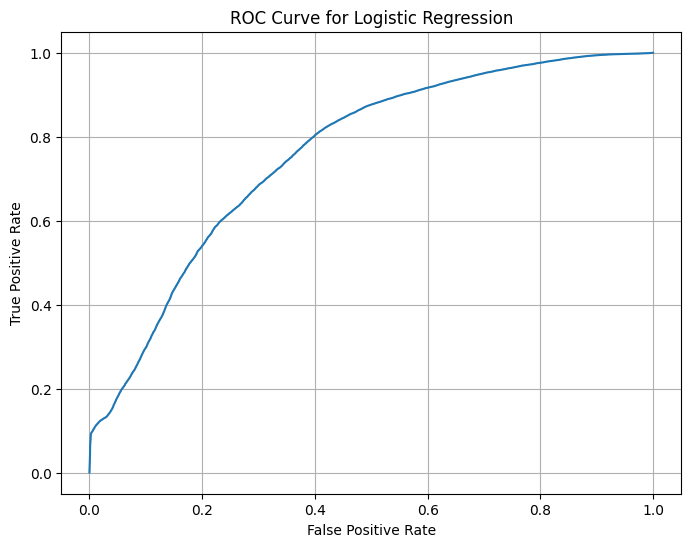

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_standardized_selected)[:, 1])

plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr)
plt.title('ROC Curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [ ]:
coefficients = logreg.coef_
intercept = logreg.intercept_

# Get the feature names that the model was trained on
# This list should match the one used in logreg.fit()
trained_features = ['V4', 'V10', 'Sueño_total', 'V2', 'V11', 'P6', 'P1', 'V2_cuadrado', 'V8', 'V6_x_V8', 'V6', 'V3', 'V5', 'V6_x_V10']

# Create a DataFrame for the coefficients
summary_df = pd.DataFrame({'Feature': trained_features, 'Coefficient': coefficients[0]})

# Add the intercept as a new row
summary_df = pd.concat([summary_df, pd.DataFrame({'Feature': ['Intercept'], 'Coefficient': [intercept[0]]})], ignore_index=True)

# Print the summary table
print("Summary of Logistic Regression Coefficients:")
print(summary_df)

Summary of Logistic Regression Coefficients:
        Feature  Coefficient
0            V4     0.011118
1           V10    -0.559814
2   Sueño_total     0.289827
3            V2     0.256076
4           V11     0.545903
5            P6    -0.097966
6            P1    -0.060678
7   V2_cuadrado     0.022647
8            V8    -0.708279
9       V6_x_V8     0.711498
10           V6    -0.348960
11           V3    -0.023716
12           V5    -0.024313
13     V6_x_V10     0.298833
14    Intercept     0.024550


## KNN

In [ ]:
knn = KNeighborsClassifier()

# Define the parameter grid for k (1 to 30)
param_grid = {'n_neighbors': range(1, 31)}

# Create a StratifiedKFold cross-validator (equivalent to trainControl in R)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

# Create a GridSearchCV object to find the best k value
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='accuracy',  # Use accuracy as the metric
    cv=cv,  # Use the StratifiedKFold cross-validator
    n_jobs=-1  # Use all available CPU cores for parallel processing
)

grid_search.fit(X_combined_balanced_standardized[['V4', 'V10', 'Sueño_total', 'V2', 'V11', 'P6', 'P1', 'V2_cuadrado', 'V8', 'V6_x_V8', 'V6', 'V3', 'V5', 'V6_x_V10']], y_combined_balanced)

# Get the best KNN model and its hyperparameters
best_knn_model = grid_search.best_estimator_
best_k = grid_search.best_params_['n_neighbors']

print(f"Best k: {best_k}")

# Evaluate the best model on the test set
y_pred_knn = best_knn_model.predict(X_test_standardized_selected)

# Print the evaluation metrics
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy_knn}")

Best k: 1
              precision    recall  f1-score   support

           0       0.90      0.87      0.89     28364
           1       0.92      0.93      0.92     41636

    accuracy                           0.91     70000
   macro avg       0.91      0.90      0.90     70000
weighted avg       0.91      0.91      0.91     70000

[[24806  3558]
 [ 2861 38775]]
Accuracy: 0.9083


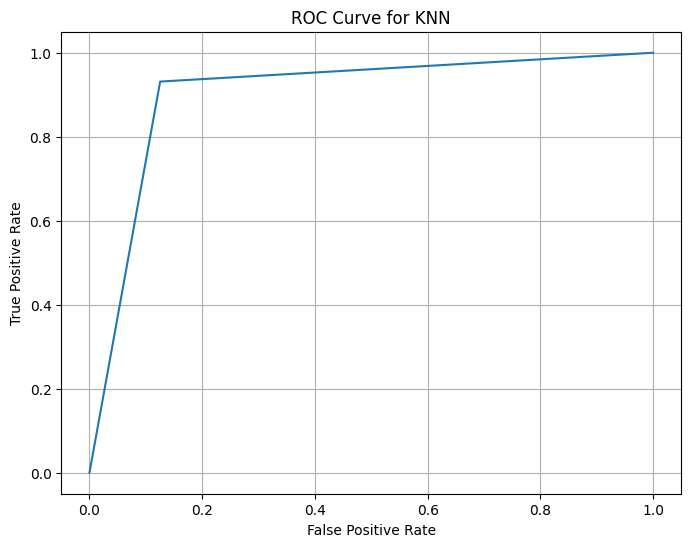

In [ ]:
y_pred_knn = best_knn_model.predict(X_test_standardized_selected)
y_pred_proba_knn = best_knn_model.predict_proba(X_test_standardized_selected)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba_knn)

plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr)
plt.title('ROC Curve for KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [ ]:

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

cv_scores = cross_val_score(
    best_knn_model,
    X_train_standardized_selected, # Use the selected features for training data
    y_combined_balanced,         # Use the balanced target variable
    cv=cv,
    scoring='roc_auc',           # Or 'accuracy', 'f1', etc.
    n_jobs=-1                    # Use all available cores
)

# Print the cross-validation scores
print("Cross-validation AUC-ROC scores for Best KNN model:", cv_scores)

# Print the mean and standard deviation of the cross-validation scores
print("Mean CV AUC-ROC:", cv_scores.mean())
print("Standard Deviation CV AUC-ROC:", cv_scores.std())plit.
# - A small difference between mean CV score and test score suggests the model generalizes well.

Cross-validation AUC-ROC scores for Best KNN model: [0.94769853 0.94530684 0.94772891 0.94832696 0.94712991 0.94712991
 0.94942724 0.94794814 0.94609139 0.94923842]
Mean CV AUC-ROC: 0.9476026242876292
Standard Deviation CV AUC-ROC: 0.0012114290043117872


In [ ]:
roc_auc_logreg = roc_auc_score(y_test,y_pred_proba_knn)
print("AUC-ROC:", roc_auc_logreg)


AUC-ROC: 0.9029223632976892


## Ensambles

## Boosting

In [ ]:
# AdaBoost
ada_boost = AdaBoostClassifier(n_estimators=50, random_state=random_state)  # Adjust n_estimators as needed

# Define the list of features used during training (from stepwise selection)
trained_features = ['V4', 'V10', 'Sueño_total', 'V2', 'V11', 'P6', 'P1', 'V2_cuadrado', 'V8', 'V6_x_V8', 'V6', 'V3', 'V5', 'V6_x_V10']

# Select only the trained_features from the training data before fitting
X_train_standardized_selected = X_combined_balanced_standardized[trained_features]

# Train the AdaBoost model on the selected features
ada_boost.fit(X_train_standardized_selected, y_combined_balanced)

y_pred_ada = ada_boost.predict(X_test_standardized_selected)

# Evaluate the model
print(classification_report(y_test, y_pred_ada))
print(confusion_matrix(y_test, y_pred_ada))
roc_auc_ada = roc_auc_score(y_test, ada_boost.predict_proba(X_test_standardized_selected)[:, 1])
print("AUC-ROC AdaBoost:", roc_auc_ada)

              precision    recall  f1-score   support

           0       0.74      0.56      0.64     28364
           1       0.74      0.87      0.80     41636

    accuracy                           0.74     70000
   macro avg       0.74      0.71      0.72     70000
weighted avg       0.74      0.74      0.73     70000

[[15889 12475]
 [ 5543 36093]]
AUC-ROC AdaBoost: 0.7784352944746038


In [ ]:
# XGBoost (already imported as xgb)

# Define the list of features used during training (from stepwise selection)
# Ensure this list is consistent with the one used for other models
trained_features = ['V4', 'V10', 'Sueño_total', 'V2', 'V11', 'P6', 'P1', 'V2_cuadrado', 'V8', 'V6_x_V8', 'V6', 'V3', 'V5', 'V6_x_V10']

# Select only the trained_features from the training data before fitting
X_train_standardized_selected = X_combined_balanced_standardized[trained_features]

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=random_state)

# Train the XGBoost model on the selected features
# Assuming y_combined_balanced is your target variable for the balanced training data
xgb_classifier.fit(X_train_standardized_selected, y_combined_balanced)


y_pred_xgb = xgb_classifier.predict(X_test_standardized_selected)

# Evaluate the model
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
roc_auc_xgb = roc_auc_score(y_test, xgb_classifier.predict_proba(X_test_standardized_selected)[:, 1])
print("AUC-ROC XGBoost:", roc_auc_xgb)

              precision    recall  f1-score   support

           0       0.77      0.76      0.77     28364
           1       0.84      0.85      0.84     41636

    accuracy                           0.81     70000
   macro avg       0.81      0.80      0.81     70000
weighted avg       0.81      0.81      0.81     70000

[[21572  6792]
 [ 6330 35306]]
AUC-ROC XGBoost: 0.890899185230029


In [ ]:
# LightGBM (already imported as lgb)

# Define the list of features used during training (from stepwise selection)
# Ensure this list is consistent with the one used for other models
trained_features = ['V4', 'V10', 'Sueño_total', 'V2', 'V11', 'P6', 'P1', 'V2_cuadrado', 'V8', 'V6_x_V8', 'V6', 'V3', 'V5', 'V6_x_V10']

# Select only the trained_features from the training data before fitting
X_train_standardized_selected = X_combined_balanced_standardized[trained_features]

# Initialize the LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=random_state)

# Train the LightGBM model on the selected features
# Assuming y_combined_balanced is your target variable for the balanced training data
lgb_classifier.fit(X_train_standardized_selected, y_combined_balanced)

y_pred_lgb = lgb_classifier.predict(X_test_standardized_selected)

# Evaluate the model
print(classification_report(y_test, y_pred_lgb))
print(confusion_matrix(y_test, y_pred_lgb))
roc_auc_lgb = roc_auc_score(y_test, lgb_classifier.predict_proba(X_test_standardized_selected)[:, 1])
print("AUC-ROC LightGBM:", roc_auc_lgb)

[LightGBM] [Info] Number of positive: 158882, number of negative: 158882
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2148
[LightGBM] [Info] Number of data points in the train set: 317764, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     28364
           1       0.84      0.86      0.85     41636

    accuracy                           0.82     70000
   macro avg       0.81      0.81      0.81     70000
weighted avg       0.82      0.82      0.82     70000

[[21566  6798]
 [ 5928 35708]]
AUC-ROC LightGBM: 0.8957622233176139


AUC-ROC LightGBM: 0.8957622233176139


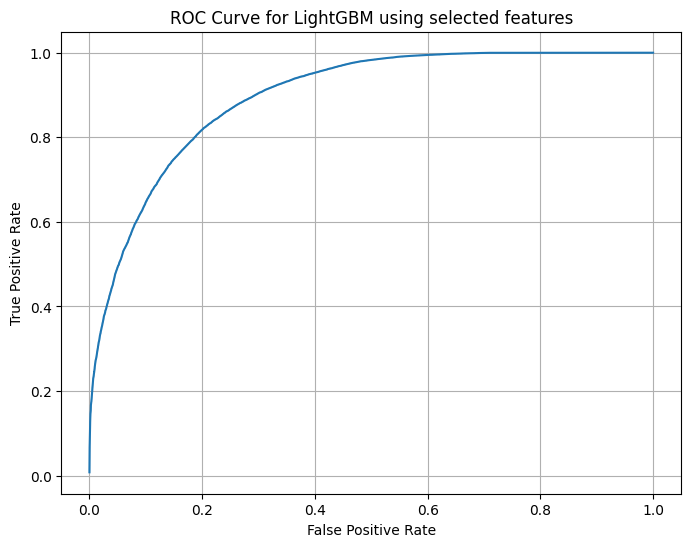

In [ ]:

fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, lgb_classifier.predict_proba(X_test_standardized_selected)[:, 1])

# Calculate the AUC-ROC score (this was already done but let's print it again for context)
roc_auc_lgb = roc_auc_score(y_test, lgb_classifier.predict_proba(X_test_standardized_selected)[:, 1])
print("AUC-ROC LightGBM:", roc_auc_lgb)


# Plot the ROC curve for LightGBM
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr_lgb, y=tpr_lgb) # Use fpr_lgb and tpr_lgb for the LightGBM curve
plt.title('ROC Curve for LightGBM using selected features') # Update title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()


## Bagging

In [ ]:
# Initialize the base estimator (e.g., Logistic Regression)
base_estimator = LogisticRegression(random_state=random_state)

# Define the list of features used during training (from stepwise selection)
# Ensure this list is consistent with the one used for other models
trained_features = ['V4', 'V10', 'Sueño_total', 'V2', 'V11', 'P6', 'P1', 'V2_cuadrado', 'V8', 'V6_x_V8', 'V6', 'V3', 'V5', 'V6_x_V10']

# Select only the trained_features from the training data before fitting
X_train_standardized_selected = X_combined_balanced_standardized[trained_features]

bagging_model = BaggingClassifier(
    estimator=base_estimator,  # Specify the base model using 'estimator'
    n_estimators=10,  # Number of base estimators (trees)
    random_state=random_state,
    n_jobs=-1  # Use all available cores
)

bagging_model.fit(X_train_standardized_selected, y_combined_balanced)



# Make predictions
y_pred_bagging = bagging_model.predict(X_test_standardized_selected)

              precision    recall  f1-score   support

           0       0.58      0.75      0.66     28364
           1       0.79      0.63      0.70     41636

    accuracy                           0.68     70000
   macro avg       0.69      0.69      0.68     70000
weighted avg       0.71      0.68      0.68     70000

[[21374  6990]
 [15375 26261]]
AUC-ROC Bagging: 0.7717891830804621


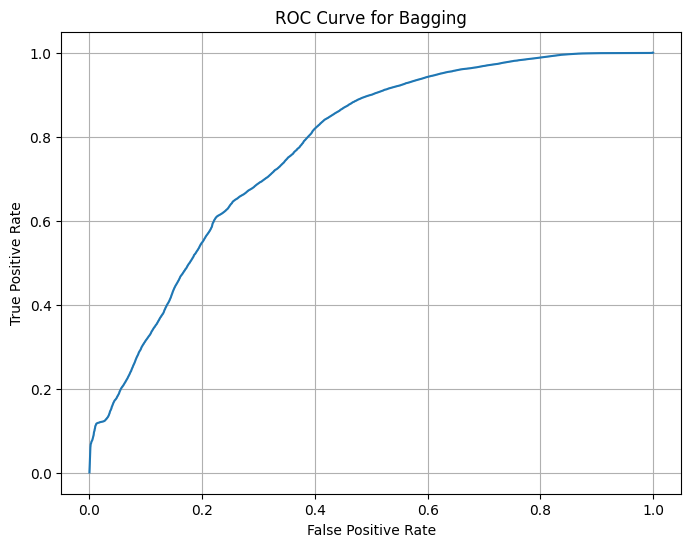

In [ ]:
print(classification_report(y_test, y_pred_bagging))
print(confusion_matrix(y_test, y_pred_bagging))

# Use the correctly selected test features for predict_proba as well
roc_auc_bagging = roc_auc_score(y_test, bagging_model.predict_proba(X_test_standardized_selected)[:, 1])
print("AUC-ROC Bagging:", roc_auc_bagging)

# Use the correctly selected test features for roc_curve as well
fpr, tpr, thresholds = roc_curve(y_test, bagging_model.predict_proba(X_test_standardized_selected)[:, 1])

plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr)
plt.title('ROC Curve for Bagging')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

#Calculo de predicciones

Dado los resultados con el gradient boosting fueron los mejores en cuanto a la curva de COR y el AUC la prediccion de los datos se hara usando este modelo

In [ ]:
df_test_standardized.head()

,P1,P2,P6,V2,V3,V4,V5,V6,V8,V10,V11,V6_x_V8,V6_x_V10,V2_cuadrado,Calidad_sueño,Sueño_total,id
0,0.458968,-1.030589,0.841004,1.997927,0.704473,-0.226245,-0.393883,0.070977,-1.010338,0.424513,0.804034,-1.001248,0.180084,1.125534,-0.205393,0.650507,1
1,-2.201686,0.371901,-0.074336,0.626409,0.653729,0.597753,-0.393883,0.376401,0.373575,0.424513,-1.296020,0.330899,0.413393,-0.230927,-0.479263,-1.331334,2
2,-0.130302,-0.288903,-0.476193,-0.620425,0.704473,-0.650363,2.538822,0.459871,-0.192571,0.424513,1.575089,-0.184544,0.477154,-0.230927,0.577240,1.607652,3
3,0.614498,1.284089,-0.632471,-0.246375,-1.078323,0.597753,-0.393883,-0.181330,1.308166,0.424513,-0.327586,0.867181,-0.012649,-0.354242,-0.118353,-0.306762,4
4,-0.906294,0.152321,0.171243,1.000459,-0.212297,1.009753,-0.393883,0.143065,1.901272,0.424513,-0.810377,1.600141,0.235151,-0.001914,-0.406168,-0.877210,5


In [ ]:
X_external_test_final = df_test_standardized[trained_features]

predictions = best_knn_model.predict(X_external_test_final)


# Check if 'id' is in df_test_standardized
if 'id' in df_test_standardized.columns:
    # Create the result DataFrame
    submission_df = pd.DataFrame({
        'id': df_test_standardized['id'],
        'isalert': predictions
    })

    print("\nPrediction DataFrame for external test data:")
    print(submission_df.head())



Prediction DataFrame for external test data:
   id  isalert
0   1        1
1   2        0
2   3        0
3   4        1
4   5        0


In [ ]:
submission_df.head(1000)

,id,isalert
0,1,1
1,2,0
2,3,0
3,4,1
4,5,0
...,...,...
995,996,0
996,997,1
997,998,0
998,999,1


In [ ]:

predictions_lgb = lgb_classifier.predict(X_external_test_final)

if 'id' in df_test_standardized.columns:
    submission_df_lgb = pd.DataFrame({
        'id': df_test_standardized['id'],
        'isalert': predictions_lgb
    })

    print("\nPrediction DataFrame for external test data using LightGBM:")
    print(submission_df_lgb.head())


submission_df_lgb.head(1000)


Prediction DataFrame for external test data using LightGBM:
   id  isalert
0   1        1
1   2        0
2   3        1
3   4        1
4   5        0


,id,isalert
0,1,1
1,2,0
2,3,1
3,4,1
4,5,0
...,...,...
995,996,0
996,997,1
997,998,0
998,999,1


In [ ]:
from sklearn.metrics import cohen_kappa_score
#Calculos de cohesion entre mejores modelos

kappa_score_xgb_lgb = cohen_kappa_score(y_pred_xgb, y_pred_lgb)

print(f"\nCohen's Kappa Score between XGBoost and LightGBM predictions on the test split: {kappa_score_xgb_lgb:.4f}")



Cohen's Kappa Score between XGBoost and LightGBM predictions on the test split: 0.9054


In [ ]:
testelco=pd.read_excel('/content/testelco.xlsx')

In [ ]:
testelco.head()

,id,Fecha de nacimiento,tipo cliente,Factura online,Antigüedad Equipo,Plan de datos,facturación,mora,Fecha inicio contrato,minutos
0,13,1996-10-28 20:37:48.858,2,0,18,1,319690,0,2016-08-01 18:35:57.816,1202
1,14,1985-11-08 12:29:16.237,2,1,6,1,333812,0,2016-04-01 19:20:55.326,1403
2,20,1987-08-15 05:31:09.530,2,0,35,1,224201,43,2017-10-12 05:47:50.487,659
3,30,1981-11-06 04:06:28.190,1,1,11,1,210614,33,2018-02-09 20:47:49.340,912
4,37,1986-08-03 13:43:36.300,1,0,34,1,267116,15,2017-02-01 17:42:17.169,1622


In [ ]:
testelco['edad'] = (datetime.now().year - pd.to_datetime(testelco['Fecha de nacimiento']).dt.year)


In [ ]:
testelco_encoded = pd.get_dummies(testelco,  columns=['tipo cliente','Factura online','Plan de datos'])


In [ ]:
testelco_encoded['meses_contrato'] = (datetime.now().year - pd.to_datetime(testelco_encoded['Fecha inicio contrato']).dt.year) * 12 + (datetime.now().month - pd.to_datetime(testelco_encoded['Fecha inicio contrato']).dt.month)

In [ ]:
testelco_encoded['Antigüedad_Equipo_Factura_online_0'] = testelco_encoded['Antigüedad Equipo'] * testelco_encoded['Factura online_0']
testelco_encoded['Antigüedad_Equipo_Factura_online_1'] = testelco_encoded['Antigüedad Equipo'] * testelco_encoded['Factura online_1']
testelco_encoded['Fecha_inicio_contrato_mora'] = pd.to_numeric(pd.to_datetime(testelco_encoded['Fecha inicio contrato'])) * testelco_encoded['mora']


In [ ]:
X_scaled_testelco = scaler.fit_transform(testelco_encoded.select_dtypes(include=['number']))

In [ ]:
# Create a DataFrame from the scaled features:
selected_features_testelco = pd.DataFrame(X_scaled_testelco, columns=testelco_encoded.select_dtypes(include=['number']).columns, index=testelco_encoded.index).loc[:, ['facturación', 'edad', 'Fecha_inicio_contrato_mora', 'meses_contrato', 'mora']]

In [ ]:
y_pred_gb_test= gb_classifier.predict(selected_features_testelco)
y_pred_gb_df = pd.DataFrame({'prediction': y_pred_gb_test})



In [ ]:
y_pred_gb_df.head(10)

,prediction
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,1
8,0
9,0


In [ ]:
df_final=pd.concat([testelco['id'],y_pred_gb_df],axis=1)

In [ ]:
df_final.head(100)

,id,prediction
0,13,0
1,14,0
2,20,0
3,30,0
4,37,0
...,...,...
95,854,0
96,856,0
97,857,1
98,862,0


In [ ]:
df_final['prediction'].value_counts()

,count
prediction,
0,1129
1,871


In [ ]:
submission_df.to_csv('df_prediccion.csv', index=False)

#PCA

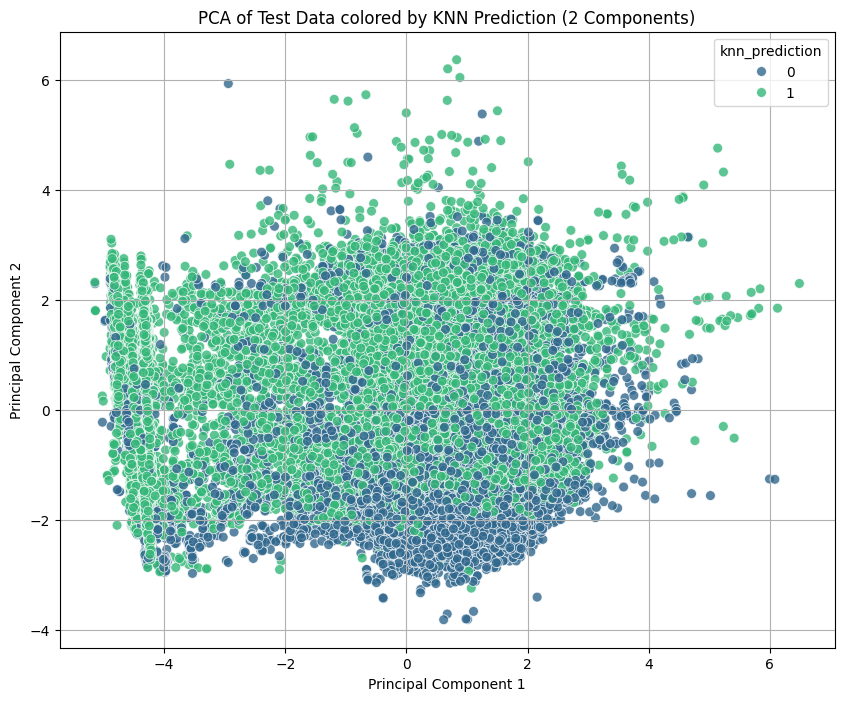

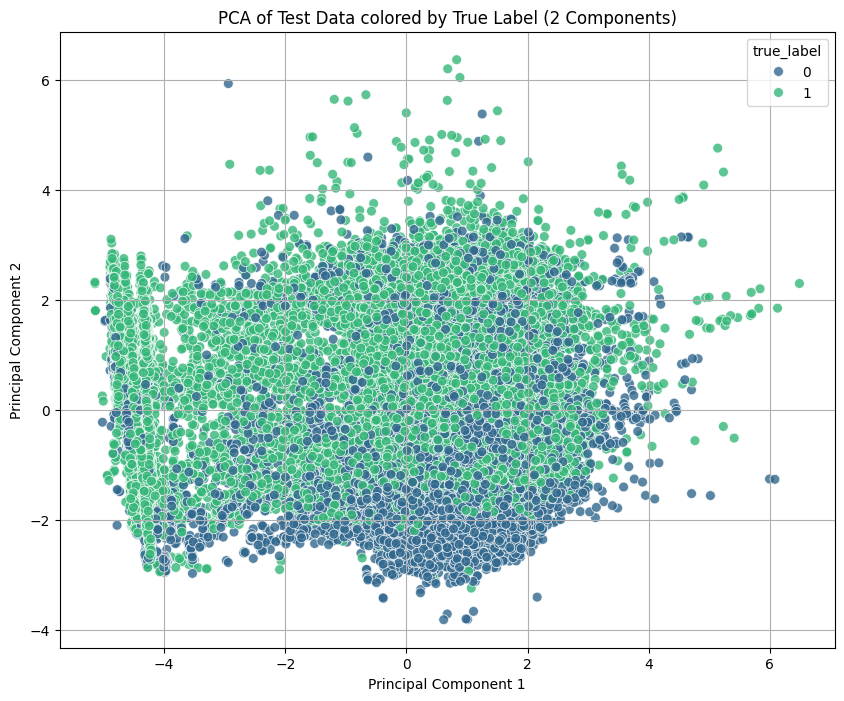

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_standardized_selected)

# Create a DataFrame for the PCA results
# The columns will be the two principal components
pca_df = pd.DataFrame(data = X_test_pca, columns = ['principal component 1', 'principal component 2'])

pca_df['true_label'] = y_test.values # Use .values to avoid potential index issues
pca_df['knn_prediction'] = y_pred_knn

# Visualize the PCA results, coloring by KNN predictions
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='principal component 1',
    y='principal component 2',
    hue='knn_prediction',  # Use KNN predictions to color the points
    data=pca_df,
    palette='viridis',   # Use a suitable color palette
    s=50,                # Adjust point size
    alpha=0.8            # Adjust transparency
)
plt.title('PCA of Test Data colored by KNN Prediction (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='principal component 1',
    y='principal component 2',
    hue='true_label',  # Use true labels to color the points
    data=pca_df,
    palette='viridis',
    s=50,
    alpha=0.8
)
plt.title('PCA of Test Data colored by True Label (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()